In [1]:
import galprime as gp

import numpy as np

from matplotlib import pyplot as plt

from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo


from tqdm import tqdm

In [2]:
bd_table = Table.read("../pdata/Simard_BD_Table.fits")

print(len(bd_table), bd_table.colnames)

config = gp.read_config_file("disk_bulge.gprime")



678593 ['objID', 'z', 'Sp', 'Scale', 'Vmax', 'gg2d', 'e_gg2d', 'rg2d', 'e_rg2d', '__B_T_g', '__B_T_r', 'Re', 'e_Re', 'ellip_b', 'phib', 'Rd', 'e_Rd', 'i', 'e_i', 'phid', 'e_phid', 'ggMag', 'rgMag', 'nb', '_RA', '_DE', 'ellip_d']


In [3]:
keys = config["KEYS"].values()
keys.extend(config["BINS"].keys())
print(keys)

['gg2d', '__B_T_g', 'Rd', 'nb', 'Re', 'ellip_d', 'ellip_b', 'z']


In [4]:
bd_table_trimmed = gp.check_and_remove_masked(bd_table)
binlist = gp.bin_catalogue(bd_table_trimmed, 
                           bin_params=config["BINS"], 
                           params=config["KEYS"])

Removed 1948 rows with masked values


{'MAG': 18.051094216254896, 'FBULGE': 0.855085656261783, 'REFF_BULGE': 5.452106188393653, 'N_BULGE': 4.4321353370038565, 'REFF_DISK': 3.6056998647301803, 'ELLIP_DISK': 0.6779848444761924, 'ELLIP_BULGE': 0.6284540927458591, 'SHAPE': 451, 'M0': 27.0, 'PA': 1.7228183493602107, 'BULGE_MAG': 18.2210701628305, 'BULGE_M0': 27.0, 'BULGE_REFF': 5.452106188393653, 'BULGE_N': 4.4321353370038565, 'BULGE_ELLIP': 0.6284540927458591, 'BULGE_PA': 1.7228183493602107, 'BULGE_X0': 225.5, 'BULGE_Y0': 225.5, 'BULGE_SHAPE': (451, 451), 'DISK_MAG': 20.14831578021582, 'DISK_M0': 27.0, 'DISK_REFF': 3.6056998647301803, 'DISK_N': 1.0, 'DISK_ELLIP': 0.6779848444761924, 'DISK_PA': 1.7228183493602107, 'DISK_X0': 225.5, 'DISK_Y0': 225.5, 'DISK_SHAPE': (451, 451)}


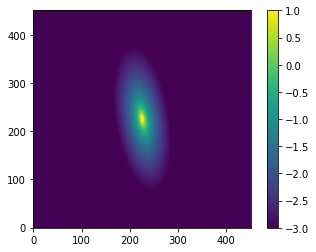

In [5]:

b = binlist.bins[0]
model_template = gp.BulgeDiskSersicModel()
keys, kde = gp.setup_kde(model_template, config, b.objects)

params = gp.sample_kde(config, keys, kde, model=model_template)
params = gp.update_required(params, config)

z, z_params = model_template.generate(params)

print(z_params)

plt.imshow(np.log10(z), origin="lower", vmin=-3, vmax=1)
plt.colorbar()